In [3]:
import pandas as pd
import numpy as np
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_csv('repeated_letters_words_v9.csv')

### Supervised Classifier Model

In [4]:
ngrams = [(2, i) for i in range(2, 15)]

df = df.sample(frac = 1)

pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer='char')),
    # ('hashing', HashingVectorizer(analyzer='char')),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

parameters = {
    # 'vect__ngram_range': ngrams,
    'vect': [CountVectorizer(analyzer='char')],   # CountVectorizer(analyzer='char_wb')
    'tfidf__use_idf': [(True, True), (False, False), (True, False), (False, True)],
    'clf': [MultinomialNB(), DecisionTreeClassifier(), RandomForestClassifier(), SVC(), KNeighborsClassifier()],
}

X_train, X_test, y_train, y_test = train_test_split(df['emphasized'], df['actual'], test_size=0.2, random_state=42)

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Model:", best_model)
print("Best Parameters:", best_params)

y_pred = best_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Best Model: Pipeline(steps=[('vect', CountVectorizer(analyzer='char')),
                ('tfidf', TfidfTransformer(use_idf=(True, True))),
                ('clf', RandomForestClassifier())])
Best Parameters: {'clf': RandomForestClassifier(), 'tfidf__use_idf': (True, True), 'vect': CountVectorizer(analyzer='char')}
Classification Report:
               precision    recall  f1-score   support

         all       1.00      1.00      1.00         7
     amazing       1.00      1.00      1.00        22
     awesome       1.00      1.00      1.00        22
         bad       1.00      1.00      1.00         8
   beautiful       1.00      1.00      1.00        26
      better       1.00      1.00      1.00        12
      boring       1.00      1.00      1.00        12
         but       1.00      1.00      1.00         9
        cool       1.00      1.00      1.00         4
        cute       1.00      1.00      1.00         7
   delicious       1.00      1.00      1.00        27
   excellen

In [13]:
best_model.predict(["beauuuutiiiiifll"])[0]

'beautiful'

In [ ]:
with open('model_v10.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [5]:
import pickle
with open('model_v10.pkl', 'rb') as file:
    model = pickle.load(file)

repeating_word = 'puuuuuuuuuuurfctttttt'
model.predict([repeating_word])[0]

'perfect'

### Model Testing

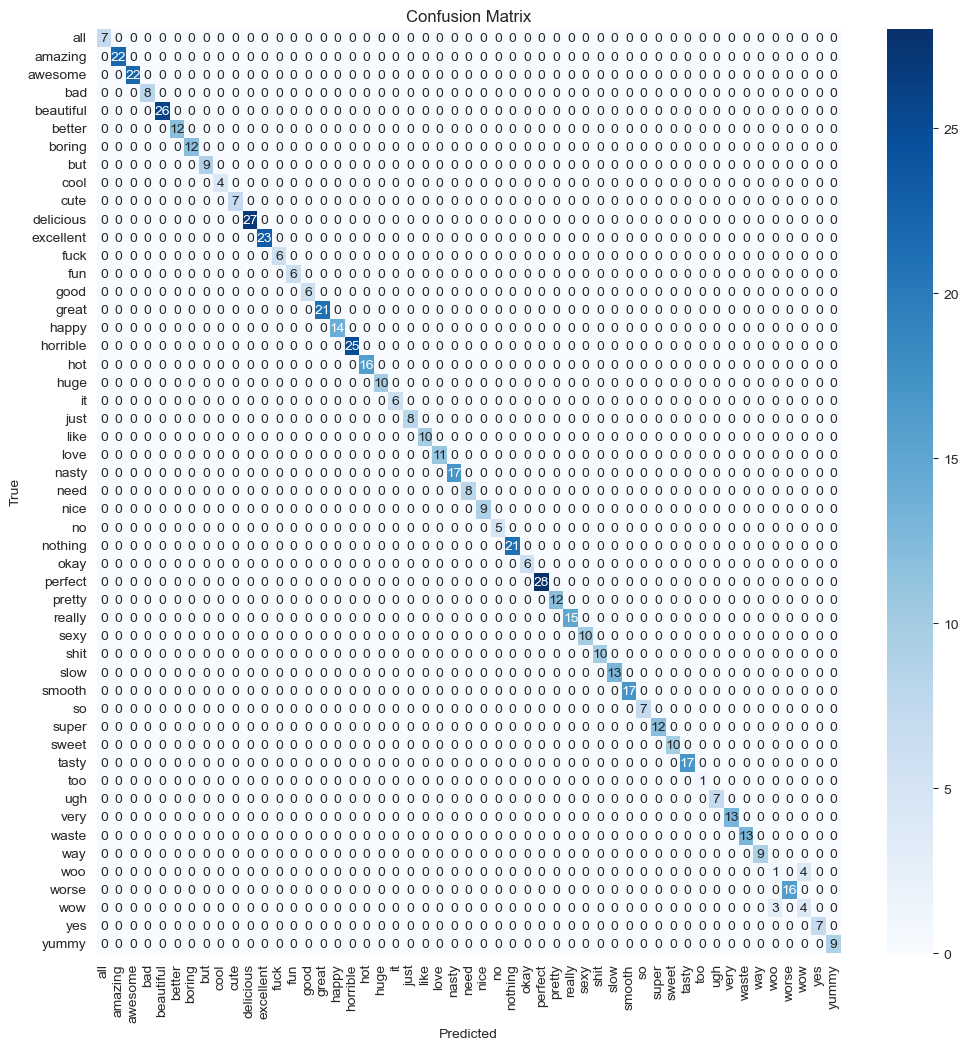

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12,12))

labels = np.unique(df['actual'])

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

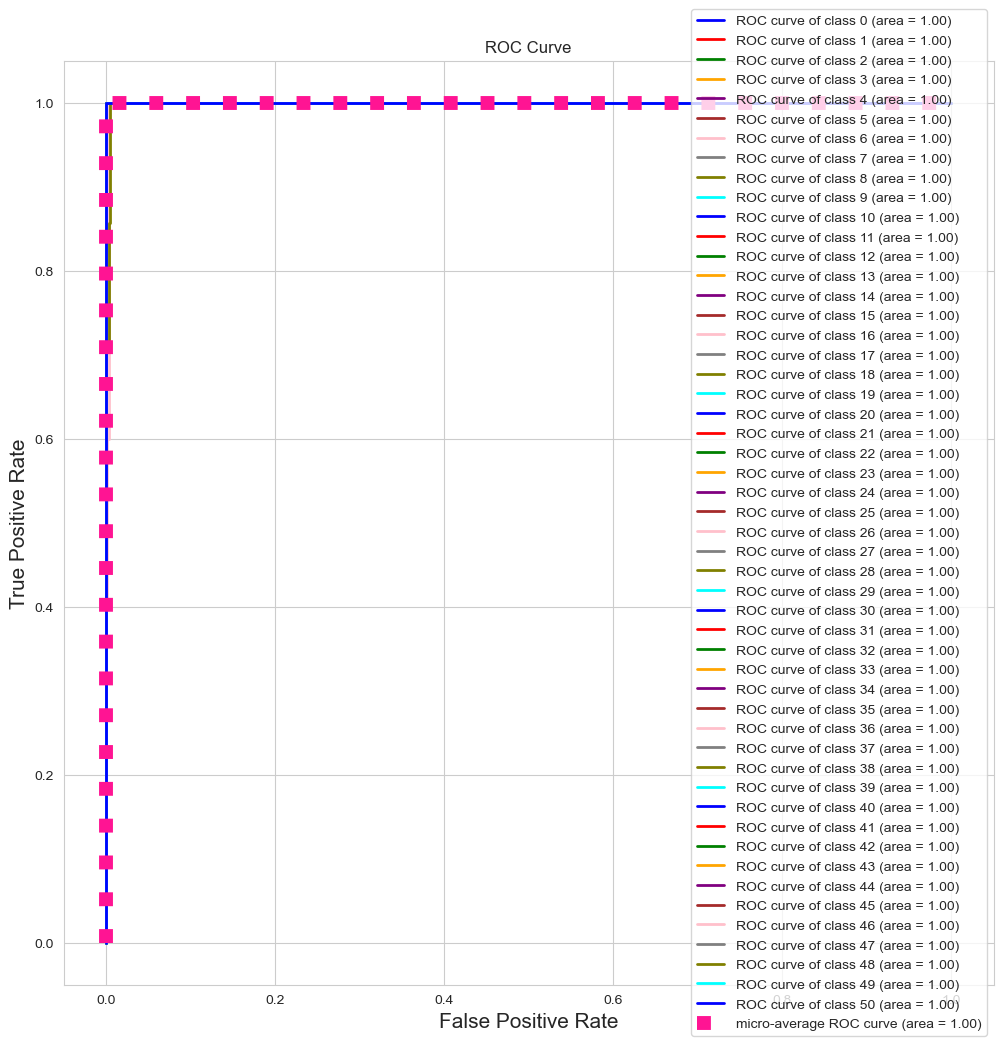

In [8]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize

y_score = model.predict_proba(X_test)

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(12,12))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=10)

plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('ROC Curve')
plt.legend(loc="right")
plt.show()

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U11'), dtype('<U5')) -> None

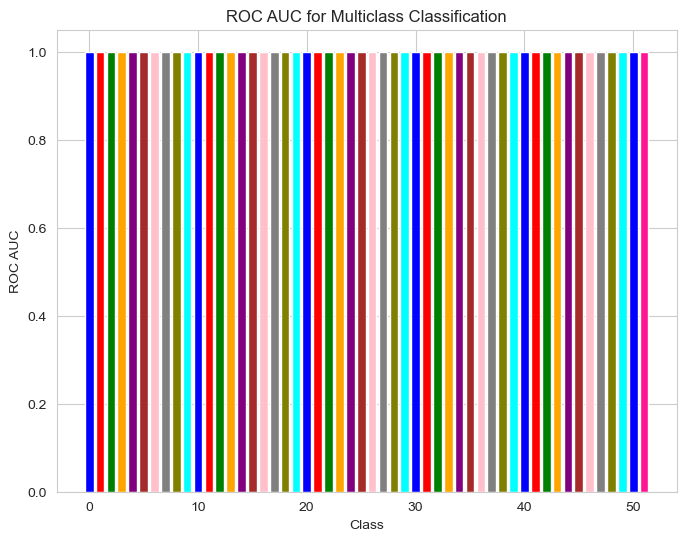

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

y_score = model.predict_proba(X_test)

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

n_classes = y_test_bin.shape[1]
roc_auc = dict()
for i in range(n_classes):
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

roc_auc["micro"] = roc_auc_score(y_test_bin, y_score, average="micro")

plt.figure(figsize=(8,6))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
for i, color in zip(range(n_classes), colors):
    plt.bar(i, roc_auc[i], color=color, align='center',
            label='ROC AUC of class {0} (AUC = {1:0.2f})'
            ''.format(i, roc_auc[i]))

plt.bar(n_classes, roc_auc["micro"], color='deeppink', align='center',
        label='micro-average ROC AUC (AUC = {0:0.2f})'
        ''.format(roc_auc["micro"]))

plt.xlabel('Class')
plt.ylabel('ROC AUC')
plt.title('ROC AUC for Multiclass Classification')
plt.xticks(range(n_classes+1), np.arange(n_classes).astype(str) + ['micro'])
plt.legend(loc="lower right")
plt.show()